/tmp/ipython-input-73-2196394938.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sentiment_df['Tweet Date'] = pd.to_datetime(sentiment_df['Tweet Date'], utc=True)



Distribusi Label NaikTurun:
Label NaikTurun
0    0.540541
1    0.459459
Name: proportion, dtype: float64


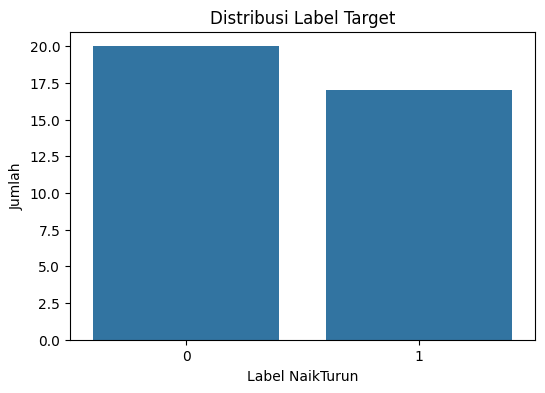

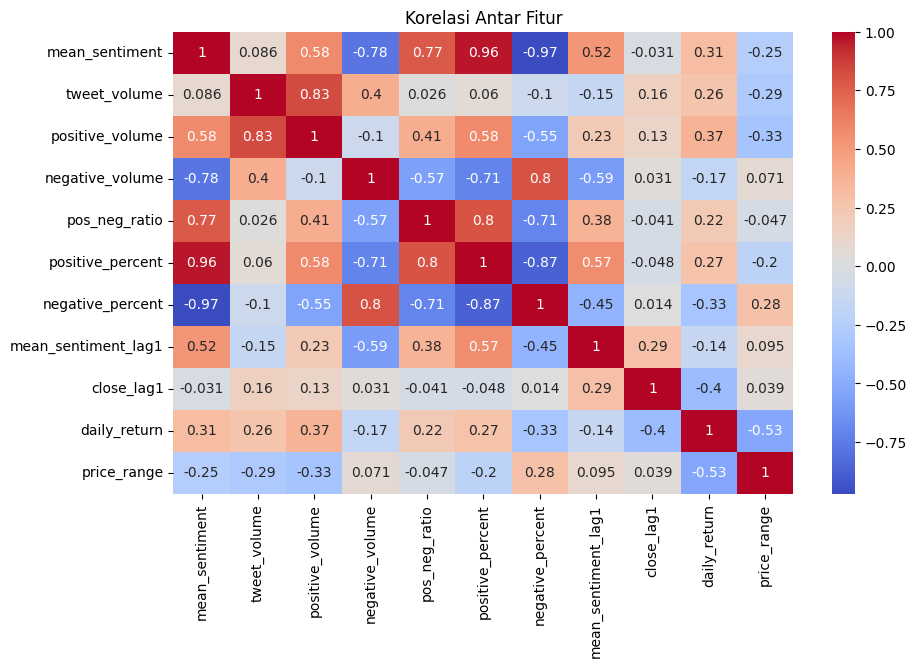


--- Evaluasi Model Awal ---

Model: SVM
Akurasi: 0.6250
Confusion Matrix:
 [[2 1]
 [2 3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.75      0.60      0.67         5

    accuracy                           0.62         8
   macro avg       0.62      0.63      0.62         8
weighted avg       0.66      0.62      0.63         8


Model: Naive Bayes
Akurasi: 1.0000
Confusion Matrix:
 [[3 0]
 [0 5]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8


--- Best Params dari GridSearchCV ---
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

--- Evaluasi SVM Setelah Tuning ---
Akurasi: 0.8750
Con

In [73]:
# =============================================================================
# 1. IMPORT LIBRARY
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# =============================================================================
# 2. LOAD DAN PREPROCESSING DATA SENTIMEN
# =============================================================================
sentiment_df = pd.read_csv("ID-SMSA.csv")
sentiment_df['Tweet Date'] = pd.to_datetime(sentiment_df['Tweet Date'], utc=True)
sentiment_df['Date'] = sentiment_df['Tweet Date'].dt.date
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
sentiment_df['Sentiment Score'] = sentiment_df['Sentiment'].map(sentiment_map)
sentiment_df.dropna(subset=['Sentiment Score'], inplace=True)

sentiment_df['is_positive'] = (sentiment_df['Sentiment'] == 'Positive').astype(int)
sentiment_df['is_negative'] = (sentiment_df['Sentiment'] == 'Negative').astype(int)
sentiment_df['is_neutral'] = (sentiment_df['Sentiment'] == 'Neutral').astype(int)

daily_sentiment_features = sentiment_df.groupby('Date').agg(
    mean_sentiment=('Sentiment Score', 'mean'),
    tweet_volume=('Sentiment', 'count'),
    positive_volume=('is_positive', 'sum'),
    negative_volume=('is_negative', 'sum'),
    neutral_volume=('is_neutral', 'sum')
).reset_index()

daily_sentiment_features['pos_neg_ratio'] = daily_sentiment_features['positive_volume'] / (daily_sentiment_features['negative_volume'] + 1)
daily_sentiment_features['positive_percent'] = daily_sentiment_features['positive_volume'] / daily_sentiment_features['tweet_volume']
daily_sentiment_features['negative_percent'] = daily_sentiment_features['negative_volume'] / daily_sentiment_features['tweet_volume']

# =============================================================================
# 3. LOAD DATA IHSG DAN PREPROCESS
# =============================================================================
ihsg_df = pd.read_csv("IHSG_2024_2025.csv", skiprows=3)
ihsg_df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
ihsg_df['Date'] = pd.to_datetime(ihsg_df['Date'])
ihsg_df = ihsg_df.sort_values('Date').reset_index(drop=True)
ihsg_df['Label NaikTurun'] = (ihsg_df['Close'].diff() > 0).astype(int)

# =============================================================================
# 4. MERGE, FITUR LAG, DAN FITUR IHSG TEKNIKAL
# =============================================================================
merged_df = pd.merge(daily_sentiment_features, ihsg_df[['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Label NaikTurun']], on='Date')

# Fitur lag
merged_df['mean_sentiment_lag1'] = merged_df['mean_sentiment'].shift(1)

# Fitur teknikal IHSG
merged_df['close_lag1'] = merged_df['Close'].shift(1)
merged_df['daily_return'] = merged_df['Close'].pct_change()
merged_df['price_range'] = merged_df['High'] - merged_df['Low']
merged_df.dropna(inplace=True)

# Fitur akhir
feature_columns = [
    'mean_sentiment', 'tweet_volume', 'positive_volume', 'negative_volume',
    'pos_neg_ratio', 'positive_percent', 'negative_percent', 'mean_sentiment_lag1',
    'close_lag1', 'daily_return', 'price_range'
]

X = merged_df[feature_columns]
y = merged_df['Label NaikTurun']

# =============================================================================
# 5. CEK DISTRIBUSI LABEL & VISUALISASI KORELASI
# =============================================================================
print("\nDistribusi Label NaikTurun:")
print(y.value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Distribusi Label Target")
plt.xlabel("Label NaikTurun")
plt.ylabel("Jumlah")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(X, columns=feature_columns).corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi Antar Fitur")
plt.show()

# =============================================================================
# 6. NORMALISASI FITUR & SPLIT
# =============================================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True
)

# =============================================================================
# 7. TRAIN MODEL & EVALUASI (SVM & NAIVE BAYES)
# =============================================================================
models = {
    'SVM': SVC(kernel='rbf', class_weight='balanced', random_state=42),
    'Naive Bayes': GaussianNB()
}

print("\n--- Evaluasi Model Awal ---")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\nModel: {name}")
    print(f"Akurasi: {accuracy_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# =============================================================================
# 8. TUNING SVM DENGAN GRIDSEARCHCV
# =============================================================================
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5)
grid.fit(X_train, y_train)

print("\n--- Best Params dari GridSearchCV ---")
print(grid.best_params_)

best_svm = grid.best_estimator_
y_pred_tuned = best_svm.predict(X_test)

print("\n--- Evaluasi SVM Setelah Tuning ---")
print(f"Akurasi: {accuracy_score(y_test, y_pred_tuned):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_tuned, zero_division=0))

# =============================================================================
# 9. CROSS VALIDATION UNTUK PERBANDINGAN
# =============================================================================
svm_scores = cross_val_score(SVC(kernel='rbf', class_weight='balanced'), X_scaled, y, cv=5)
nb_scores = cross_val_score(GaussianNB(), X_scaled, y, cv=5)

print("\n--- Cross-Validation (5-Fold) ---")
print(f"Rata-rata Akurasi SVM : {svm_scores.mean():.4f}")
print(f"Rata-rata Akurasi Naive Bayes : {nb_scores.mean():.4f}")
